In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /build/python-pytorch/src/pytorch-cuda/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [4]:
def normalize_position_and_rotation_to_previous(nodes, edge_index, y: list[torch.tensor]) -> tuple:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the frame before it, so that the first frame is always [0, 0, 0]
    new_pos = [positions[0] - positions[0]]
    for i in range(1, positions.shape[0]):
        new_pos.append(positions[i] - positions[i - 1])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the frame before it
    new_rot = [R.from_quat(rotations[0]).inv() * R.from_quat(rotations[0])]
    for i in range(1, rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[i - 1]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [8]:
def normalize_position_and_rotation_to_first(nodes, edge_index, y):
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the first frame
    new_pos = []
    for i in range(positions.shape[0]):
        new_pos.append(positions[i] - positions[0])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the first frame
    new_rot =  []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [9]:
dataset = MultipleSequenceGraphDataset(
    basedir,
    train_sequences,
    transform=normalize_position_and_rotation_to_first,
    graph_length=7,
)
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss()

In [10]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
MODEL_LETTER = "D"

os.makedirs(f"models/{MODEL_LETTER}", exist_ok=True)

loss_history = []
for epoch in range(1, 151):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
       
    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_{epoch}.pth")

torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_final.pth")

Epoch 1:   0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_209784/2008863461.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /build/python-pytorch/src/pytorch-cuda/torch/csrc/utils/tensor_new.cpp:245.)
  new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)
Epoch 1: 100%|██████████| 159/159 [00:33<00:00,  4.74it/s, loss=7.14] 


Epoch 1 loss: 41.874314113233076


Epoch 2: 100%|██████████| 159/159 [00:34<00:00,  4.63it/s, loss=8.01]


Epoch 2 loss: 7.739287826250184


Epoch 3: 100%|██████████| 159/159 [00:33<00:00,  4.81it/s, loss=5.74]


Epoch 3 loss: 7.135299007847624


Epoch 4: 100%|██████████| 159/159 [00:33<00:00,  4.78it/s, loss=6.28]


Epoch 4 loss: 7.1265412336625396


Epoch 5: 100%|██████████| 159/159 [00:33<00:00,  4.70it/s, loss=5.87]   


Epoch 5 loss: 111629.75581513111


Epoch 6: 100%|██████████| 159/159 [00:33<00:00,  4.80it/s, loss=5.16]


Epoch 6 loss: 6.892893944146498


Epoch 7: 100%|██████████| 159/159 [00:33<00:00,  4.75it/s, loss=6.91]


Epoch 7 loss: 6.932709720899474


Epoch 8: 100%|██████████| 159/159 [00:31<00:00,  5.06it/s, loss=7.61]


Epoch 8 loss: 6.995822702563784


Epoch 9: 100%|██████████| 159/159 [00:32<00:00,  4.94it/s, loss=5.67]


Epoch 9 loss: 7.437482596943213


Epoch 10: 100%|██████████| 159/159 [00:32<00:00,  4.88it/s, loss=6.52]


Epoch 10 loss: 7.610540237066881


Epoch 11: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=6.82]


Epoch 11 loss: 7.61679952249587


Epoch 12: 100%|██████████| 159/159 [00:31<00:00,  5.01it/s, loss=6.38]


Epoch 12 loss: 7.096339312739342


Epoch 13: 100%|██████████| 159/159 [00:31<00:00,  5.03it/s, loss=5.98]


Epoch 13 loss: 7.66229441180919


Epoch 14: 100%|██████████| 159/159 [00:30<00:00,  5.13it/s, loss=7.76]


Epoch 14 loss: 7.354902471386412


Epoch 15: 100%|██████████| 159/159 [00:31<00:00,  4.98it/s, loss=5.78]


Epoch 15 loss: 7.127601713504431


Epoch 16: 100%|██████████| 159/159 [00:31<00:00,  4.99it/s, loss=6.28]


Epoch 16 loss: 7.272452945229392


Epoch 17: 100%|██████████| 159/159 [00:32<00:00,  4.97it/s, loss=9.38]


Epoch 17 loss: 7.284372626610522


Epoch 18: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=10.5]


Epoch 18 loss: 7.239677636128552


Epoch 19: 100%|██████████| 159/159 [00:31<00:00,  5.13it/s, loss=5.68]


Epoch 19 loss: 7.22212426167614


Epoch 20: 100%|██████████| 159/159 [00:31<00:00,  5.11it/s, loss=5.87]


Epoch 20 loss: 7.388633734025295


Epoch 21: 100%|██████████| 159/159 [00:31<00:00,  5.03it/s, loss=5.56]


Epoch 21 loss: 7.389728765067814


Epoch 22: 100%|██████████| 159/159 [00:32<00:00,  4.92it/s, loss=6.72]


Epoch 22 loss: 7.151041915581661


Epoch 23: 100%|██████████| 159/159 [00:31<00:00,  4.99it/s, loss=6.56]


Epoch 23 loss: 7.262116633121322


Epoch 24: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=9.13]


Epoch 24 loss: 7.139342580951235


Epoch 25: 100%|██████████| 159/159 [00:32<00:00,  4.97it/s, loss=8.86]


Epoch 25 loss: 7.447385593030438


Epoch 26: 100%|██████████| 159/159 [00:31<00:00,  5.02it/s, loss=6.42]


Epoch 26 loss: 7.325293762878802


Epoch 27: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=9.53]


Epoch 27 loss: 7.056568514625981


Epoch 28: 100%|██████████| 159/159 [00:31<00:00,  5.01it/s, loss=7.02]


Epoch 28 loss: 7.255756995962851


Epoch 29: 100%|██████████| 159/159 [00:32<00:00,  4.87it/s, loss=5.98]


Epoch 29 loss: 7.167782078748979


Epoch 30: 100%|██████████| 159/159 [00:31<00:00,  4.99it/s, loss=6.65]


Epoch 30 loss: 7.511389159556455


Epoch 31: 100%|██████████| 159/159 [00:32<00:00,  4.89it/s, loss=7.29]


Epoch 31 loss: 7.120986809520601


Epoch 32: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=5.54]


Epoch 32 loss: 7.063254062484646


Epoch 33: 100%|██████████| 159/159 [00:33<00:00,  4.71it/s, loss=6.3] 


Epoch 33 loss: 7.205432358028004


Epoch 34: 100%|██████████| 159/159 [00:34<00:00,  4.65it/s, loss=6.59]


Epoch 34 loss: 7.264970914372858


Epoch 35: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=6.08]


Epoch 35 loss: 7.119294106585425


Epoch 36: 100%|██████████| 159/159 [00:34<00:00,  4.63it/s, loss=5.38]


Epoch 36 loss: 7.12170250910633


Epoch 37: 100%|██████████| 159/159 [00:31<00:00,  5.01it/s, loss=7.45]


Epoch 37 loss: 7.414797048148869


Epoch 38: 100%|██████████| 159/159 [00:31<00:00,  5.09it/s, loss=6.21]


Epoch 38 loss: 7.185944053362


Epoch 39: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=36.2]


Epoch 39 loss: 7.30325891986583


Epoch 40: 100%|██████████| 159/159 [00:31<00:00,  5.08it/s, loss=8.64]


Epoch 40 loss: 7.5590084603747485


Epoch 41: 100%|██████████| 159/159 [00:31<00:00,  4.99it/s, loss=6.42]


Epoch 41 loss: 6.986289180299771


Epoch 42: 100%|██████████| 159/159 [00:31<00:00,  5.10it/s, loss=7.06]


Epoch 42 loss: 6.911966266871998


Epoch 43: 100%|██████████| 159/159 [00:31<00:00,  5.11it/s, loss=7.13]


Epoch 43 loss: 7.147182950433695


Epoch 44: 100%|██████████| 159/159 [00:31<00:00,  5.00it/s, loss=8.84]


Epoch 44 loss: 10.408668359120687


Epoch 45: 100%|██████████| 159/159 [00:31<00:00,  4.98it/s, loss=5.84]


Epoch 45 loss: 6.70440415916203


Epoch 46: 100%|██████████| 159/159 [00:31<00:00,  5.11it/s, loss=5.83]


Epoch 46 loss: 6.760741593702784


Epoch 47: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=6.1] 


Epoch 47 loss: 6.963692401190224


Epoch 48: 100%|██████████| 159/159 [00:30<00:00,  5.17it/s, loss=6.75]


Epoch 48 loss: 6.787298703343613


Epoch 49: 100%|██████████| 159/159 [00:30<00:00,  5.13it/s, loss=10.7]


Epoch 49 loss: 7.142100472120369


Epoch 50: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=7.9] 


Epoch 50 loss: 6.966865848445292


Epoch 51: 100%|██████████| 159/159 [00:31<00:00,  5.03it/s, loss=6.36]


Epoch 51 loss: 6.923770085820612


Epoch 52: 100%|██████████| 159/159 [00:30<00:00,  5.16it/s, loss=5.38]


Epoch 52 loss: 7.008215463386391


Epoch 53: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=8.24]


Epoch 53 loss: 6.905645256522317


Epoch 54: 100%|██████████| 159/159 [00:31<00:00,  5.12it/s, loss=6.96]


Epoch 54 loss: 7.047700735008192


Epoch 55: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=5.73]


Epoch 55 loss: 8.697927040124089


Epoch 56: 100%|██████████| 159/159 [00:31<00:00,  4.98it/s, loss=4.25]


Epoch 56 loss: 6.75372484495055


Epoch 57: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=7.59]


Epoch 57 loss: 6.7451326502194195


Epoch 58: 100%|██████████| 159/159 [00:31<00:00,  5.01it/s, loss=6.01]


Epoch 58 loss: 6.747391448830658


Epoch 59: 100%|██████████| 159/159 [00:31<00:00,  5.11it/s, loss=6.92]


Epoch 59 loss: 6.768621390720583


Epoch 60: 100%|██████████| 159/159 [00:31<00:00,  5.03it/s, loss=7.43]


Epoch 60 loss: 6.867198767152223


Epoch 61: 100%|██████████| 159/159 [00:31<00:00,  5.04it/s, loss=8.08]


Epoch 61 loss: 7.024829471636118


Epoch 62: 100%|██████████| 159/159 [00:31<00:00,  5.05it/s, loss=4.94]


Epoch 62 loss: 6.535793403409562


Epoch 63: 100%|██████████| 159/159 [00:31<00:00,  5.02it/s, loss=6.03]


Epoch 63 loss: 6.723447685721536


Epoch 64: 100%|██████████| 159/159 [00:31<00:00,  5.01it/s, loss=4.69]


Epoch 64 loss: 6.695467436088706


Epoch 65: 100%|██████████| 159/159 [00:31<00:00,  5.03it/s, loss=5.98]


Epoch 65 loss: 6.635384079795213


Epoch 66: 100%|██████████| 159/159 [00:30<00:00,  5.24it/s, loss=4.61]


Epoch 66 loss: 6.62246614432185


Epoch 67: 100%|██████████| 159/159 [00:29<00:00,  5.35it/s, loss=5.43]


Epoch 67 loss: 6.642901369610673


Epoch 68: 100%|██████████| 159/159 [00:31<00:00,  5.00it/s, loss=5.2] 


Epoch 68 loss: 6.614325739302725


Epoch 69: 100%|██████████| 159/159 [00:32<00:00,  4.91it/s, loss=5.99]


Epoch 69 loss: 6.523446697858894


Epoch 70: 100%|██████████| 159/159 [00:32<00:00,  4.87it/s, loss=6.36]


Epoch 70 loss: 6.9065290427058


Epoch 71: 100%|██████████| 159/159 [00:32<00:00,  4.93it/s, loss=8.95]


Epoch 71 loss: 6.361566459607778


Epoch 72: 100%|██████████| 159/159 [00:33<00:00,  4.80it/s, loss=4.41]


Epoch 72 loss: 6.393077658407344


Epoch 73: 100%|██████████| 159/159 [00:33<00:00,  4.68it/s, loss=6.4] 


Epoch 73 loss: 6.2701896001707835


Epoch 74: 100%|██████████| 159/159 [00:32<00:00,  4.85it/s, loss=5.38]


Epoch 74 loss: 6.299631094782607


Epoch 75: 100%|██████████| 159/159 [00:33<00:00,  4.75it/s, loss=8.45]


Epoch 75 loss: 6.219765231294452


Epoch 76: 100%|██████████| 159/159 [00:32<00:00,  4.91it/s, loss=4.77]


Epoch 76 loss: 6.167605628007613


Epoch 77: 100%|██████████| 159/159 [00:33<00:00,  4.70it/s, loss=5.23]


Epoch 77 loss: 6.09179173775439


Epoch 78: 100%|██████████| 159/159 [00:32<00:00,  4.90it/s, loss=4.85]


Epoch 78 loss: 6.043446243933912


Epoch 79: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=6.2] 


Epoch 79 loss: 6.025875181522009


Epoch 80: 100%|██████████| 159/159 [00:33<00:00,  4.75it/s, loss=5.33]


Epoch 80 loss: 6.019866184618488


Epoch 81: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=6.83]


Epoch 81 loss: 6.170880125753535


Epoch 82: 100%|██████████| 159/159 [00:32<00:00,  4.82it/s, loss=5.82]


Epoch 82 loss: 6.046280770931604


Epoch 83: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=6.31]


Epoch 83 loss: 6.0709457757338035


Epoch 84: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=6.17]


Epoch 84 loss: 5.859347163506274


Epoch 85: 100%|██████████| 159/159 [00:33<00:00,  4.82it/s, loss=6.84]


Epoch 85 loss: 5.9406747623059735


Epoch 86: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=4.53]


Epoch 86 loss: 5.88249268321871


Epoch 87: 100%|██████████| 159/159 [00:34<00:00,  4.61it/s, loss=3.94]


Epoch 87 loss: 5.818315963325261


Epoch 88: 100%|██████████| 159/159 [00:34<00:00,  4.66it/s, loss=4.48]


Epoch 88 loss: 5.865755384073317


Epoch 89: 100%|██████████| 159/159 [00:34<00:00,  4.64it/s, loss=4.88]


Epoch 89 loss: 5.809291751129822


Epoch 90: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=6.99]


Epoch 90 loss: 5.784266159969306


Epoch 91: 100%|██████████| 159/159 [00:32<00:00,  4.91it/s, loss=4.88]


Epoch 91 loss: 5.7355561241413815


Epoch 92: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=5.07]


Epoch 92 loss: 5.690151709430623


Epoch 93: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=7.99]


Epoch 93 loss: 5.721548218397224


Epoch 94: 100%|██████████| 159/159 [00:32<00:00,  4.94it/s, loss=4.13]


Epoch 94 loss: 5.784356361665066


Epoch 95: 100%|██████████| 159/159 [00:32<00:00,  4.88it/s, loss=4.64]


Epoch 95 loss: 5.793512092446381


Epoch 96: 100%|██████████| 159/159 [00:32<00:00,  4.90it/s, loss=4.64]


Epoch 96 loss: 5.634691824703096


Epoch 97: 100%|██████████| 159/159 [00:32<00:00,  4.85it/s, loss=4.52]


Epoch 97 loss: 5.6174317425901785


Epoch 98: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=4.14]


Epoch 98 loss: 6.055817185707812


Epoch 99: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=6.23]


Epoch 99 loss: 5.749027007780735


Epoch 100: 100%|██████████| 159/159 [00:33<00:00,  4.79it/s, loss=7.38]


Epoch 100 loss: 5.7615556372036725


Epoch 101: 100%|██████████| 159/159 [00:33<00:00,  4.78it/s, loss=6.8] 


Epoch 101 loss: 5.629358781958526


Epoch 102: 100%|██████████| 159/159 [00:33<00:00,  4.72it/s, loss=4.34]


Epoch 102 loss: 5.58081902048123


Epoch 103: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=6.25]


Epoch 103 loss: 5.543199177807982


Epoch 104: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=5.38]


Epoch 104 loss: 5.585741082077506


Epoch 105: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=5.29]


Epoch 105 loss: 5.52559701751613


Epoch 106: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=4.57]


Epoch 106 loss: 5.456211592416343


Epoch 107: 100%|██████████| 159/159 [00:34<00:00,  4.66it/s, loss=4.8] 


Epoch 107 loss: 5.645840415414774


Epoch 108: 100%|██████████| 159/159 [00:33<00:00,  4.69it/s, loss=4.64]


Epoch 108 loss: 5.440457525493214


Epoch 109: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=4.6] 


Epoch 109 loss: 5.441609474098158


Epoch 110: 100%|██████████| 159/159 [00:33<00:00,  4.69it/s, loss=5.93]


Epoch 110 loss: 5.422947079880433


Epoch 111: 100%|██████████| 159/159 [00:34<00:00,  4.67it/s, loss=4.43]


Epoch 111 loss: 5.395803421548328


Epoch 112: 100%|██████████| 159/159 [00:33<00:00,  4.70it/s, loss=4.89]


Epoch 112 loss: 5.414159344427241


Epoch 113: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=5.37]


Epoch 113 loss: 5.349238905516811


Epoch 114: 100%|██████████| 159/159 [00:33<00:00,  4.71it/s, loss=3.95]


Epoch 114 loss: 5.309986847751546


Epoch 115: 100%|██████████| 159/159 [00:33<00:00,  4.81it/s, loss=5.5] 


Epoch 115 loss: 5.507778942959863


Epoch 116: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=6]   


Epoch 116 loss: 5.342554743184984


Epoch 117: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=7.54]


Epoch 117 loss: 5.264833147420823


Epoch 118: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=5.88]


Epoch 118 loss: 5.2298983777843935


Epoch 119: 100%|██████████| 159/159 [00:33<00:00,  4.79it/s, loss=3.53]


Epoch 119 loss: 5.233882619150029


Epoch 120: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=5.52]


Epoch 120 loss: 5.169440422417982


Epoch 121: 100%|██████████| 159/159 [00:32<00:00,  4.87it/s, loss=4.28]


Epoch 121 loss: 5.22176567413522


Epoch 122: 100%|██████████| 159/159 [00:33<00:00,  4.76it/s, loss=3.79]


Epoch 122 loss: 5.143751592756067


Epoch 123: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=7.2] 


Epoch 123 loss: 7.684539886390638


Epoch 124: 100%|██████████| 159/159 [00:33<00:00,  4.74it/s, loss=5.26]


Epoch 124 loss: 6.475222131741122


Epoch 125: 100%|██████████| 159/159 [00:33<00:00,  4.68it/s, loss=5.53]


Epoch 125 loss: 6.3449469047522395


Epoch 126: 100%|██████████| 159/159 [00:33<00:00,  4.81it/s, loss=7.34]


Epoch 126 loss: 13.21044041375694


Epoch 127: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=8.67]


Epoch 127 loss: 6.504629270085749


Epoch 128: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=6.86]


Epoch 128 loss: 6.37599766629297


Epoch 129: 100%|██████████| 159/159 [00:33<00:00,  4.77it/s, loss=4.86]


Epoch 129 loss: 6.284510150645514


Epoch 130: 100%|██████████| 159/159 [00:33<00:00,  4.75it/s, loss=6.43]


Epoch 130 loss: 6.116176497261479


Epoch 131: 100%|██████████| 159/159 [00:33<00:00,  4.69it/s, loss=8.81]


Epoch 131 loss: 6.079217750321394


Epoch 132: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=6.22]


Epoch 132 loss: 6.0352609547429115


Epoch 133: 100%|██████████| 159/159 [00:32<00:00,  4.85it/s, loss=6.05]


Epoch 133 loss: 5.929906852590213


Epoch 134: 100%|██████████| 159/159 [00:33<00:00,  4.74it/s, loss=6.5] 


Epoch 134 loss: 5.858830147569284


Epoch 135: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=6.12]


Epoch 135 loss: 5.81603841811606


Epoch 136: 100%|██████████| 159/159 [00:33<00:00,  4.74it/s, loss=4.11]


Epoch 136 loss: 5.752906088559133


Epoch 137: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=5.18]


Epoch 137 loss: 5.709238524706858


Epoch 138: 100%|██████████| 159/159 [00:32<00:00,  4.89it/s, loss=8.73]


Epoch 138 loss: 5.6110035188542975


Epoch 139: 100%|██████████| 159/159 [00:32<00:00,  4.85it/s, loss=4.48]


Epoch 139 loss: 5.700175492268689


Epoch 140: 100%|██████████| 159/159 [00:32<00:00,  4.83it/s, loss=8.92]


Epoch 140 loss: 5.621512254079183


Epoch 141: 100%|██████████| 159/159 [00:33<00:00,  4.70it/s, loss=4.77]


Epoch 141 loss: 5.511664539013269


Epoch 142: 100%|██████████| 159/159 [00:32<00:00,  4.84it/s, loss=7.08]


Epoch 142 loss: 5.724739945909512


Epoch 143: 100%|██████████| 159/159 [00:32<00:00,  4.87it/s, loss=5.23]


Epoch 143 loss: 5.468984711844966


Epoch 144: 100%|██████████| 159/159 [00:33<00:00,  4.69it/s, loss=5.97]


Epoch 144 loss: 5.549837950640504


Epoch 145: 100%|██████████| 159/159 [00:33<00:00,  4.73it/s, loss=5]   


Epoch 145 loss: 5.551171379269294


Epoch 146: 100%|██████████| 159/159 [00:33<00:00,  4.75it/s, loss=5.61]


Epoch 146 loss: 5.451887559590849


Epoch 147: 100%|██████████| 159/159 [00:33<00:00,  4.79it/s, loss=5.83]


Epoch 147 loss: 5.443727571259505


Epoch 148: 100%|██████████| 159/159 [00:33<00:00,  4.68it/s, loss=4.31]


Epoch 148 loss: 5.456616025300896


Epoch 149: 100%|██████████| 159/159 [00:33<00:00,  4.70it/s, loss=4.61]


Epoch 149 loss: 5.419670545829917


Epoch 150: 100%|██████████| 159/159 [00:33<00:00,  4.74it/s, loss=4.57]

Epoch 150 loss: 5.395549285336861


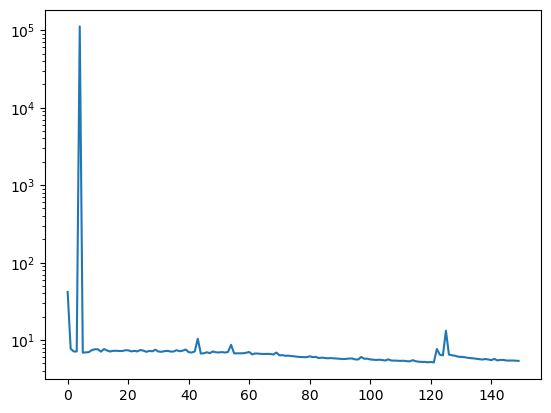

In [11]:
# plot loss
plt.plot(loss_history)
plt.yscale("log")
plt.show()